# 4.1節

リスト 4.1

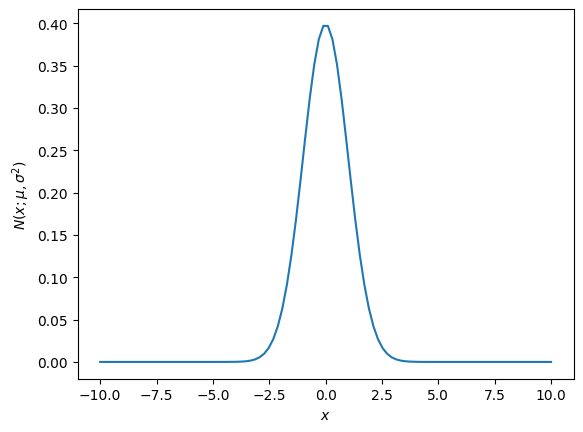

In [ ]:
import numpy as np, matplotlib.pyplot as plt, math

mu, sigma = 0, 1
x = np.linspace(-10,10,100)
N = (1/np.sqrt(2*math.pi*sigma**2))*np.exp(-(1/(2*sigma**2))*(x-mu)**2)
    
fig, ax = plt.subplots()
ax.plot(x, N.reshape(-1,)), 
plt.xlabel('$x$'), plt.ylabel('$N(x; \mu, \sigma^2)$')
plt.show()

リスト 4.2

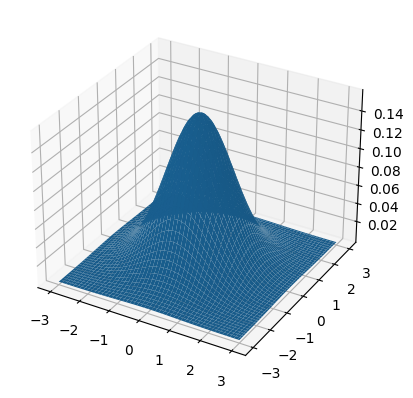

In [ ]:
mu, Sigma = np.zeros(2), 1*np.diag([1,1])

x1 = x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[np.ravel(X1), np.ravel(X2)]

detSigma = np.linalg.det(Sigma) 
invSigma = np.linalg.inv(Sigma) 
N = (1/(np.sqrt((2 * np.pi)**2 * detSigma)))*np.exp(-0.5*np.diag((X - mu) @ invSigma @ (X - mu).T)) 
N = N.reshape(X1.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X1, X2, N), plt.show()

# 4.2節

## 実践９

In [ ]:
import numpy as np, matplotlib.pyplot as plt, math

リスト 4.3

In [ ]:
def true_func(x):
    y = 1 - 1.5*x + np.sin(x) + np.cos(3*x)
    return y
    
np.random.seed(1)
x = np.linspace(-3, 3, 100)
y = true_func(x)

リスト 4.4

In [ ]:
def kernel_func(x1, x2, i, j, hp): 
    if i == j and all(x1 == x2):
      k = hp[0]**2 + hp[2]**2
    else:
      k = hp[0]**2*math.exp(-(1/(2*hp[1]**2))*np.sum((x1-x2)**2))
    return k

def kernel_matrix(x1, x2, hyperparam):
    K = np.empty((len(x1), len(x2)))
    for i in range(len(x1)):
      for j in range(len(x2)):
        K[i,j] = kernel_func(x1[i], x2[j], i, j, hyperparam)
    return K

リスト 4.5

In [ ]:
n = 4
x_data = 6*np.random.rand(n) - 3 
z_data = true_func(x_data) + np.random.normal(0, 0.1, n)

リスト 4.6

In [ ]:
!pip install GPy
import GPy

kernel = GPy.kern.RBF(1)
model = GPy.models.GPRegression(x_data.reshape(-1, 1), z_data.reshape(-1,1), kernel=kernel)

hparam_priors = 3*[None]
hparam_priors[0] = GPy.priors.Gaussian(mu=0, sigma=1)
hparam_priors[1] = GPy.priors.Gaussian(mu=0, sigma=1)
hparam_priors[2] = GPy.priors.Gaussian(mu=0, sigma=0.001)
param_name = model.parameter_names()
for i in range(3):
  hparam_priors[i].domain = "positive"
  model[param_name[i]].set_prior(hparam_priors[i])
  
model.optimize(messages=False, optimizer='scg', max_iters=1e5)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp39-cp39-linux_x86_64.whl size=3288043 sha256=ad20bfc185e1699a7a1710c3861beac35559465cf99dd34a8dc98417e6bb5bc5
  Stored in directory: /root/.cache/pip/wheels/78/fd/57/7c1e4a6f9a5380e2536af9809075ba085b1bb8d38ee84ea183
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102564 sha256=57c5d49ae8d03a9fd0dbd9ac959a5017d59e745637d56f8d8b5bb47d649f2c66
  Stored in directory: /root/.cache/pip/wheels/9c/5f/9b/c4273ae8f869387214be2b99598d1b71dbf00672576cb85e74
Successfully built GPy paramz


リスト 4.7

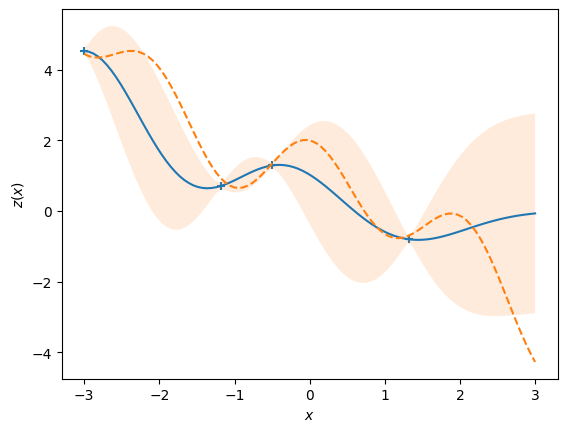

(Text(0.5, 24.0, '$x$'), Text(26.000000000000007, 0.5, '$z(x)$'), None)

In [ ]:
sigma_f = np.sqrt(model.rbf.variance[0])
q = model.rbf.lengthscale[0]
sigma_n = np.sqrt(model.Gaussian_noise.variance[0])
hyperparam = [sigma_f, q, sigma_n]

x, x_data = x.reshape(-1,1), x_data.reshape(-1,1)
K_ss = kernel_matrix(x, x, hyperparam)
K = kernel_matrix(x_data, x_data, hyperparam)
invK = np.linalg.inv(K)
k_s = kernel_matrix(x, x_data, hyperparam) 

c = invK @ z_data
z_mean = k_s @ c
z_var = K_ss - k_s @ invK @ k_s.T
z_stdv = np.sqrt(np.diag(z_var))

fig, ax = plt.subplots()
ax.plot(x, z_mean), ax.plot(x, y, ls='--')
ax.scatter(x_data, z_data, marker='+')
ax.fill_between(x.flatten(), (z_mean - 2*z_stdv).flatten(), (z_mean + 2*z_stdv).flatten(), alpha=0.15)
plt.xlabel('$x$'), plt.ylabel('$z(x)$'), plt.show()

リスト 4.8

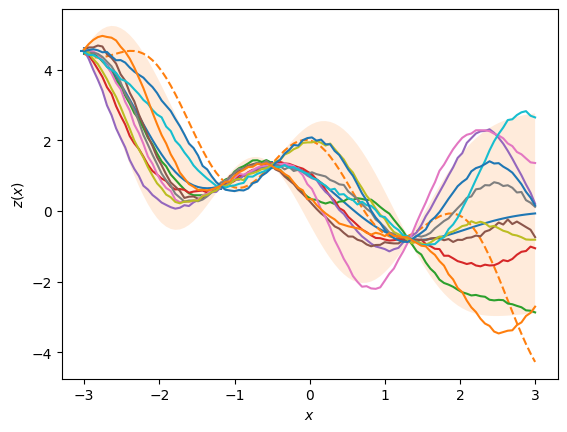

(Text(0.5, 24.0, '$x$'), Text(26.000000000000007, 0.5, '$z(x)$'), None)

In [ ]:
z_samples = np.random.multivariate_normal(z_mean, z_var, 10).T

fig, ax = plt.subplots()
ax.plot(x, z_mean), ax.plot(x, y, ls='--')
ax.plot(x, z_samples), ax.scatter(x_data, z_data, marker='+')
ax.fill_between(x.flatten(), (z_mean - 2*z_stdv).flatten(), (z_mean + 2*z_stdv).flatten(), alpha=0.15)
plt.xlabel('$x$'), plt.ylabel('$z(x)$'), plt.show()

## 実践１０

In [ ]:
import numpy as np, matplotlib.pyplot as plt, math

In [ ]:
def kernel_func(x1, x2, i, j, hp): 
    if i == j and all(x1 == x2):
      k = hp[0]**2 + hp[2]**2
    else:
      k = hp[0]**2*math.exp(-(1/(2*hp[1]**2))*np.sum((x1-x2)**2))
    return k

def kernel_matrix(x1, x2, hyperparam):
    K = np.empty((len(x1), len(x2)))
    for i in range(len(x1)):
      for j in range(len(x2)):
        K[i,j] = kernel_func(x1[i], x2[j], i, j, hyperparam)
    return K

リスト 4.9

In [ ]:
def true_func(x):
    y = np.exp(-np.sum((x-np.array([-1.2,1.2]))**2,1)) \
        + np.exp(-np.sum((x-np.array([1.2,-1.2]))**2,1))
    return y

x1 = x2 = np.linspace(-2, 2, 50)
X1, X2 = np.meshgrid(x1, x2)
x1x2 = np.c_[np.ravel(X1), np.ravel(X2)]
y = true_func(x1x2)

リスト 4.10

In [ ]:
n = 10 
x1_data = 4*np.random.rand(40)[0:n] - 2 
x2_data = 4*np.random.rand(40)[0:n] - 2 
x1x2_data = np.vstack([x1_data, x2_data]).T
z_data = true_func(x1x2_data) + np.random.normal(0, 0.01, n)

リスト 4.11

In [ ]:
hyperparam = [0.2, 0.8, 0.01]
K = kernel_matrix(x1x2_data, x1x2_data, hyperparam)
invK = np.linalg.inv(K)
K_ss = kernel_matrix(x1x2, x1x2, hyperparam)
k_s = kernel_matrix(x1x2, x1x2_data, hyperparam) 

c = invK @ z_data
z_mean = k_s @ c
z_var = K_ss - k_s @ invK @ k_s.T
z_stdv = np.sqrt(np.diag(z_var))

リスト 4.12

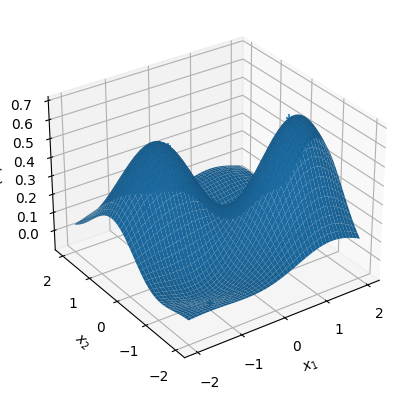

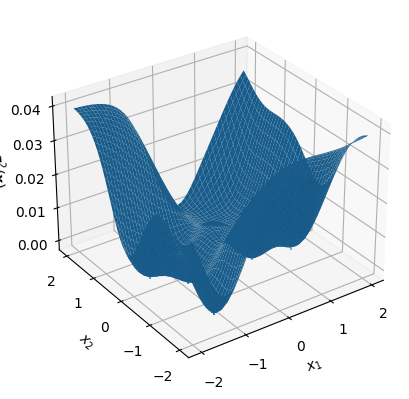

(None, None)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection="3d")
surf = ax.plot_surface(X1, X2, z_mean.reshape(50, 50))
ax.scatter(x1_data, x2_data, z_data, marker='+')
ax.set_xlabel('$x_1$'), ax.set_ylabel('$x_2$')
ax.set_zlabel('$\mu(\mathbf{x})$')
ax.view_init(azim=235), plt.show()

fig = plt.figure()
ax = plt.axes(projection="3d")
surf = ax.plot_surface(X1, X2, z_stdv.reshape(50, 50)**2)
ax.scatter(x1_data, x2_data, 0, marker='+')
ax.set_xlabel('$x_1$'), ax.set_ylabel('$x_2$')
ax.set_zlabel('$\sigma^2(\mathbf{x})$')
ax.view_init(azim=235), plt.show()